In [8]:
#import nessecary libraries
import numpy as np
from PIL import Image, ImageFont, ImageDraw
from skimage import io, filters
import matplotlib.pyplot as plt
from skimage.io import imread, imsave, imshow, show, imread_collection, imshow_collection
from IPython.display import display
import cv2
from skimage.filters import try_all_threshold
from skimage import data
from skimage.filters import threshold_li
from skimage.feature import canny
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.draw import circle_perimeter
import skimage as ski
from skimage.measure import label, regionprops
from skimage.filters import threshold_otsu



In [25]:
#Outline
#1. use the multicompartiment model to segment glomeruli or anotate using imagescope
#2. use tiffslide to open the regions
#3. view the thumbnails
#4. turn gray
#5. threshold
#6. inverse
#7. identify areas and overlay the podocyte images
#8. overlay to the bigger image


In [26]:
import xml.etree.ElementTree as ET
from tiffslide import TiffSlide
from xml.dom import minidom
slide = TiffSlide('./Images/p57.svs')
    


In [27]:
import tiffslide
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_li
from lxml import etree



# File paths
slide_path = './Images/p57.svs'  # Add the path to your whole slide image
xml_path = './Images/p57.xml'






In [28]:
def parse_xml(xml_file):
    try:
        tree = etree.parse(xml_file)
        root = tree.getroot()
       # print(etree.tostring(root, pretty_print=True).decode())  # Print the XML structure for debugging
        tiles = []
        for region in root.findall('.//Region'):
            vertices = region.findall('.//Vertex')
            if len(vertices) < 4:
                print("Error: Less than 4 vertices found")
                continue
            x_coords = [float(vertex.get('X')) for vertex in vertices]
            y_coords = [float(vertex.get('Y')) for vertex in vertices]
            x_min, x_max = min(x_coords), max(x_coords)
            y_min, y_max = min(y_coords), max(y_coords)
            width = int(x_max - x_min)
            height = int(y_max - y_min)
            tiles.append((int(x_min), int(y_min), width, height))
        return tiles
    except Exception as e:
        print(f"Error parsing XML file: {e}")
        return []
tiles = parse_xml(xml_path)
#print(tiles)


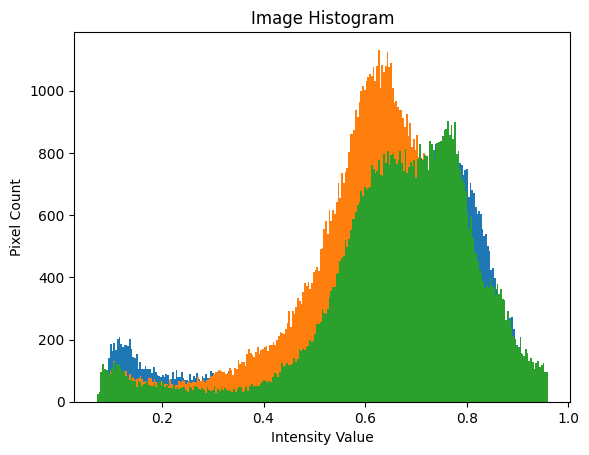

In [29]:
#plot the images histograams to understand the density distribution
import matplotlib.pyplot as plt
from skimage import data, exposure

for (x, y, width, height) in tiles:
        #print(f"Processing tile at ({x}, {y}) with size ({width}x{height})")
        tile = slide.read_region((x, y), 0, (width, height)).convert("RGB")
        tile_array = np.array(tile)
        tile_array= filters.gaussian(tile_array, sigma=1.3)
        gray_tile = np.dot(tile_array[..., :3], [0.2989, 0.5870, 0.1140])  # Convert to grayscale

        # Calculate and plot the histogram
        hist, bins = exposure.histogram(gray_tile)
        plt.hist(bins[:-1], bins, weights=hist[:-1])  # Slice 'hist' as well
        plt.title("Image Histogram")
        plt.xlabel("Intensity Value")
        plt.ylabel("Pixel Count")
       # plt.show()
#if 0.3 value is common to all tiles, why can't we use it?

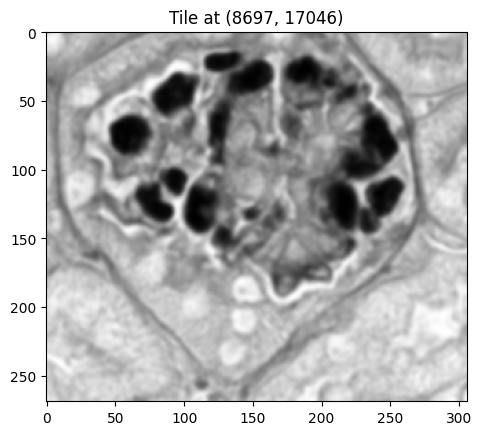

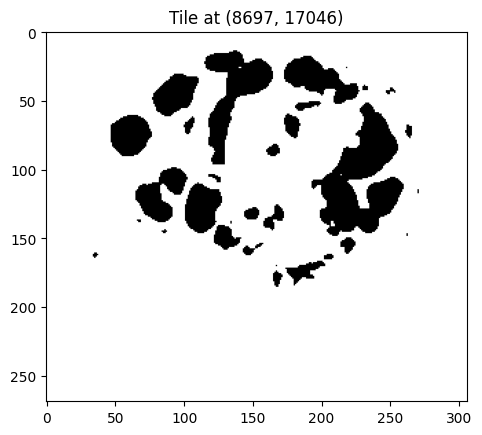

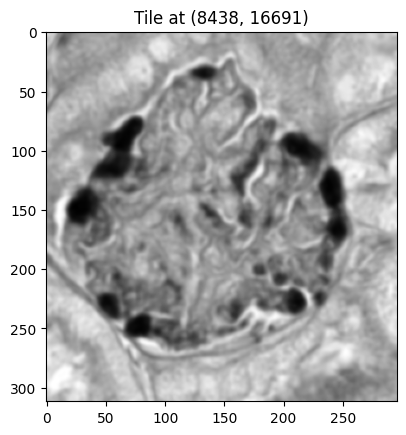

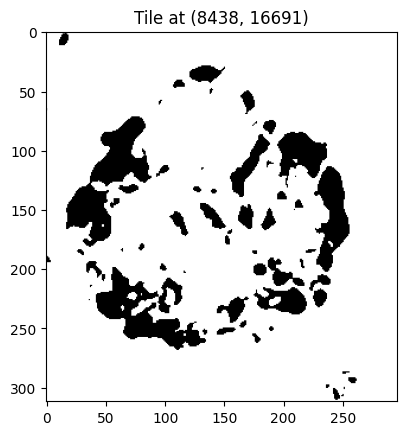

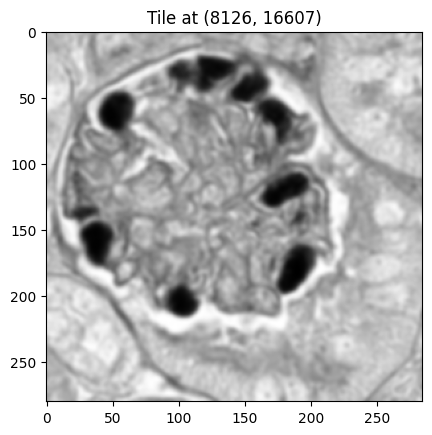

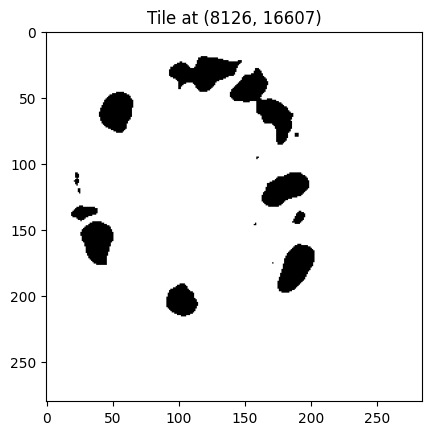

In [30]:
# Function to extract and threshold tiles
def process_tiles(slide, tiles):
    thresh_tiles=[]
    for (x, y, width, height) in tiles:
        #print(f"Processing tile at ({x}, {y}) with size ({width}x{height})")
        tile = slide.read_region((x, y), 0, (width, height)).convert("RGB")
        tile_array = np.array(tile)
        tile_array= filters.gaussian(tile_array, sigma=1.3)
        gray_tile = np.dot(tile_array[..., :3], [0.2989, 0.5870, 0.1140])  # Convert to grayscale
        initial_guess = threshold_otsu(gray_tile)
        li_thresh = threshold_li(gray_tile, initial_guess= initial_guess)
        binary_tile = gray_tile > li_thresh   #use 0.3 instead of Li's threshold
        plt.figure()
        plt.title(f"Tile at ({x}, {y})")
        plt.imshow(gray_tile, cmap='gray')
        plt.show()
        
        
        plt.figure()
        plt.title(f"Tile at ({x}, {y})")
        plt.imshow(binary_tile, cmap='gray')
        plt.show()
        thresh_tiles.append((x,y,width, height, binary_tile))
    return thresh_tiles
thresh_tiles = process_tiles(slide, tiles)


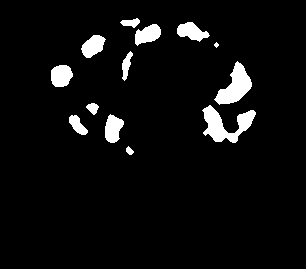

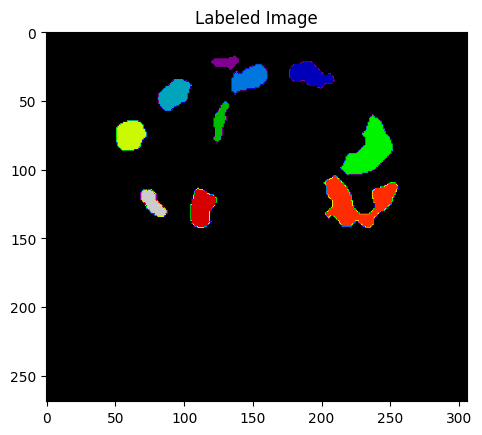

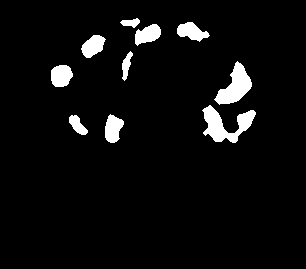

The number of podocytes in this image is: 10


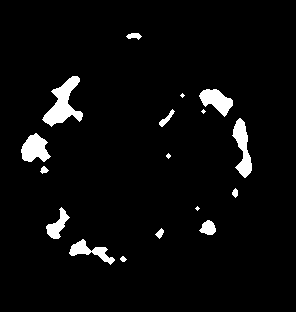

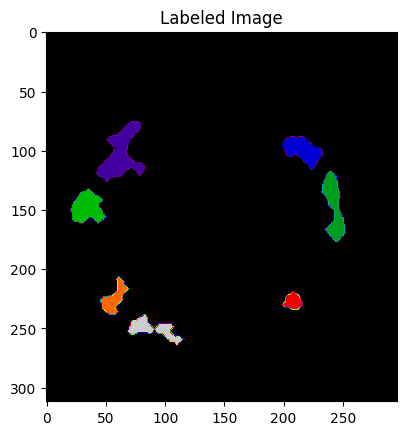

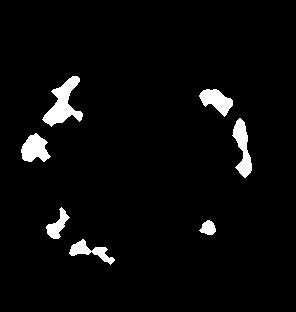

The number of podocytes in this image is: 7


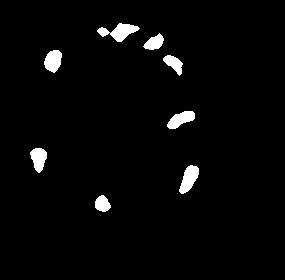

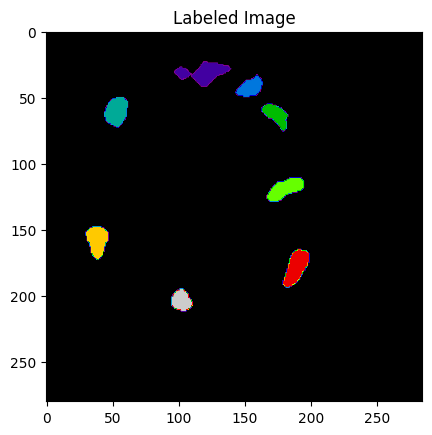

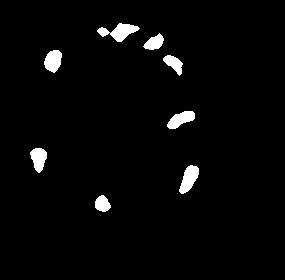

The number of podocytes in this image is: 8


In [31]:
import skimage.morphology as morph

def countRegions(thresh_tiles):
    results=[]
    for (x, y, width, height, im_thresh) in thresh_tiles:
        im_thresh= np.array(im_thresh)                  #read it as a numpy array
        im_thresh_inv= ski.util.invert(im_thresh)          #invert the image
        
        selem = morph.disk(5)
        eroded = morph.binary_erosion(im_thresh_inv)
        i=0
        for i in range(5):
            selem = morph.disk(5)
            eroded = morph.binary_erosion(eroded)
            i+=1

        selem = morph.disk(2)
        dilated= morph.binary_dilation(eroded, selem)
        display(Image.fromarray(dilated))
        
        label_image = label(dilated)                 # label the regions

        for region in regionprops(label_image):                          #label the areas
            if region.area < 100:
                for coordinates in region.coords:
                    label_image[coordinates[0], coordinates[1]] = 0
        im_thresh_inv_arr = label_image > 0
        Podocount = 0
        for region in regionprops(label_image):
            Podocount +=1                                  #Count Podocytes
        # check if it is labeling correctly  for debugging purposes
        plt.imshow(label_image, cmap='nipy_spectral')
        plt.title('Labeled Image')

        plt.show()
        cleanIm = Image.fromarray(im_thresh_inv_arr)
        display(cleanIm)
        print("The number of podocytes in this image is:", Podocount)
        results.append((x, y, width, height,im_thresh_inv_arr))
    return results
tile_result=countRegions(thresh_tiles)

In [32]:
import tifffile

def extract_metadata(slide):
    metadata ={}
    for key, value in slide.properties.items():
        metadata[key] = value
    return metadata
metadata = extract_metadata(slide)

In [11]:
# Save the overlay image as a multi-resolution TIFF with metadata
with tifffile.TiffWriter('./Images/p57_overlay.svs', bigtiff=True) as tif:
    tif.write(overaly_image_array, photometric='rgb', metadata=metadata)

In [ ]:
#Next step

#produce an overlay image

#Notes
#Maybe use color deconvolution for 